<h2 align="center">Sentiment Analysis</h2>

In [127]:
import numpy as np
import pandas  as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from scipy.special import softmax
import torch
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('Reviews.csv')
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [4]:
df['Cleaned_Text'] = df['Text'].apply(clean_text)

In [5]:
def missing_values_analysis(df):
    columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    total = df[columns].isnull().sum().sort_values(ascending=True)
    percent = (df[columns].isnull().sum()/df.shape[0]*100).sort_values(ascending=True)
    missing_data = pd.concat([total, np.round(percent,3)], axis=1, keys=['Total', 'Percent'])
    missing_data = pd.DataFrame(missing_data)
    return missing_data

def data_summary(df):
    print("Shape of the Dataset".center(80, '-'))
    print("Rows : ",df.shape[0])
    print("Columns : ",df.shape[1])
    print("Types".center(80, '-'))
    print(df.dtypes)
    print("Columns with Missing Values".center(80, '-'))
    print(missing_values_analysis(df))
    print("Duplicate Values".center(80, '-'))
    print(df.duplicated().sum())
    print("Quantiles".center(80, '-'))
    print(df.quantile([0.25,0.5,0.75]).T)

In [6]:
data_summary(df)

------------------------------Shape of the Dataset------------------------------
Rows :  568454
Columns :  11
-------------------------------------Types--------------------------------------
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
Cleaned_Text              object
dtype: object
--------------------------Columns with Missing Values---------------------------
             Total  Percent
ProfileName     16    0.003
Summary         27    0.005
--------------------------------Duplicate Values--------------------------------
0
-----------------------------------Quantiles------------------------------------
                                0.25          0.50          0.75
Id                      1.421142e+05  

In [7]:
def col_unique_values(df):
    unique_df = pd.DataFrame({'Columns':df.columns, 'Unique_Values':[df[col].nunique() for col in df.columns]})
    unique_df = unique_df.sort_values(by='Unique_Values', ascending=False)
    unique_df = unique_df.reset_index(drop=True)
    return unique_df

In [8]:
col_unique_values(df)

,Columns,Unique_Values
0,Id,568454
1,Text,393579
2,Cleaned_Text,393121
3,Summary,295742
4,UserId,256059
5,ProfileName,218416
6,ProductId,74258
7,Time,3168
8,HelpfulnessDenominator,234
9,HelpfulnessNumerator,231


In [9]:
colors = ['#B34D22','#EBE00C','#1FEB0C','#0C92EB','#EB0CD5']
def col_summary(df,col):
        a=[]
        for i in df['Score'].value_counts().index:
                a.append(str(i) + ' Stars')
        fig,axs =plt.subplots(1,2,figsize=(18,6))
        sns.barplot(y=df[col].value_counts().values.tolist(),
                        x=[str(i) for i in df[col].value_counts().index],
                        ax=axs[0])
        axs[0].set_title(col)
        plt.pie(df[col].value_counts().values,
                labels=a,
                colors=colors,
                autopct='%1.1f%%',
                shadow=True,
                startangle=90,
                explode=(0,0,0,0.1,0),
                pctdistance=0.75,
                normalize=True)
        axs[1].set_title('Percentage of Reviews')
        plt.axis('equal')
        plt.show()

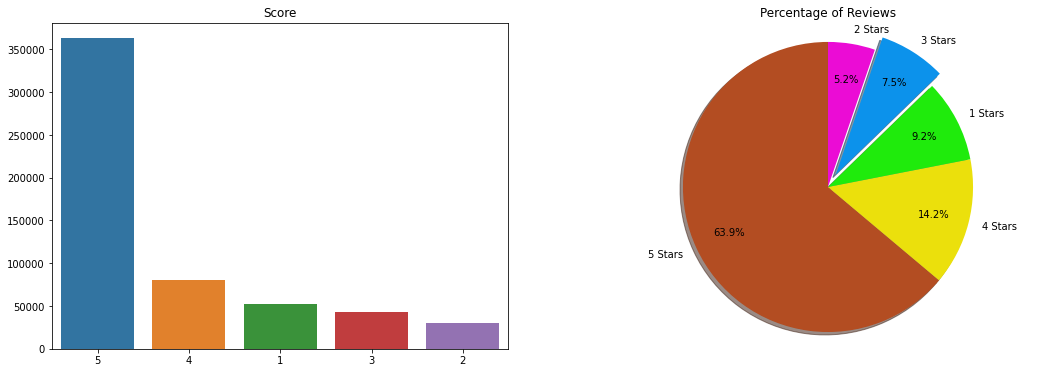

In [10]:
col_summary(df,'Score')

In [11]:
df[['Text','Cleaned_Text']].head(3)

,Text,Cleaned_Text
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...


In [12]:
sia = SentimentIntensityAnalyzer()

In [13]:
# Running polarity score on the whole dataset

res = {}
for i, row in tqdm(df.iterrows()):
    myid = row['Id']
    text = row['Text']
    res[myid] = sia.polarity_scores(text)
    

0it [00:00, ?it/s]

In [14]:
vaders = pd.DataFrame.from_dict(res, orient='index')
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders.head(3)

,Id,neg,neu,pos,compound
0,1,0.000,0.695,0.305,0.9441
1,2,0.138,0.862,0.000,-0.5664
2,3,0.091,0.754,0.155,0.8265


In [15]:
# merging the vader scores with the original dataset
vaders = vaders.merge(df, on='Id',how='left')
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...


## Plotting Vader Results

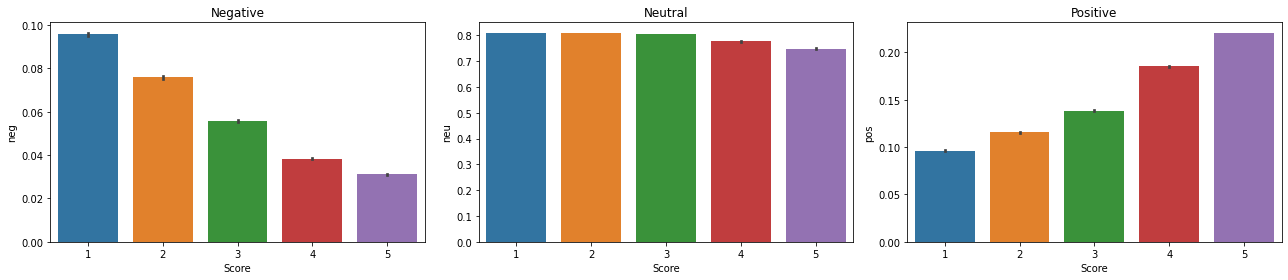

In [16]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()
plt.show()

## Roberta  Pretrained Model

In [20]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [64]:
import tensorflow as tf

In [79]:
def roberta_polarity_scores(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output.logits.detach().tolist()[0]
    scores = np.array(scores)
    scores = softmax(scores)
    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2],
    }
    return scores_dict

In [ ]:
result = {}
for i, row in tqdm(df.iterrows(),total=len(df)):
    try:
        myid = row['Id']
        text = row['Text']
        result[myid] = roberta_polarity_scores(text)
    except RuntimeError:
        print(f'broke for id {myid}')

In [84]:
results_df = pd.DataFrame(result).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(vaders,how='left')
results_df.head(3)

,Id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
0,1,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,2,0.508986,0.452414,0.038600,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...


In [94]:
results_df.rename(columns={'vader_neg':'vaders_neg','vader_neu':'vaders_neu','vader_pos':'vaders_pos','vader_compound':'vaders_compound'},inplace=True)

## Compare Scores between models

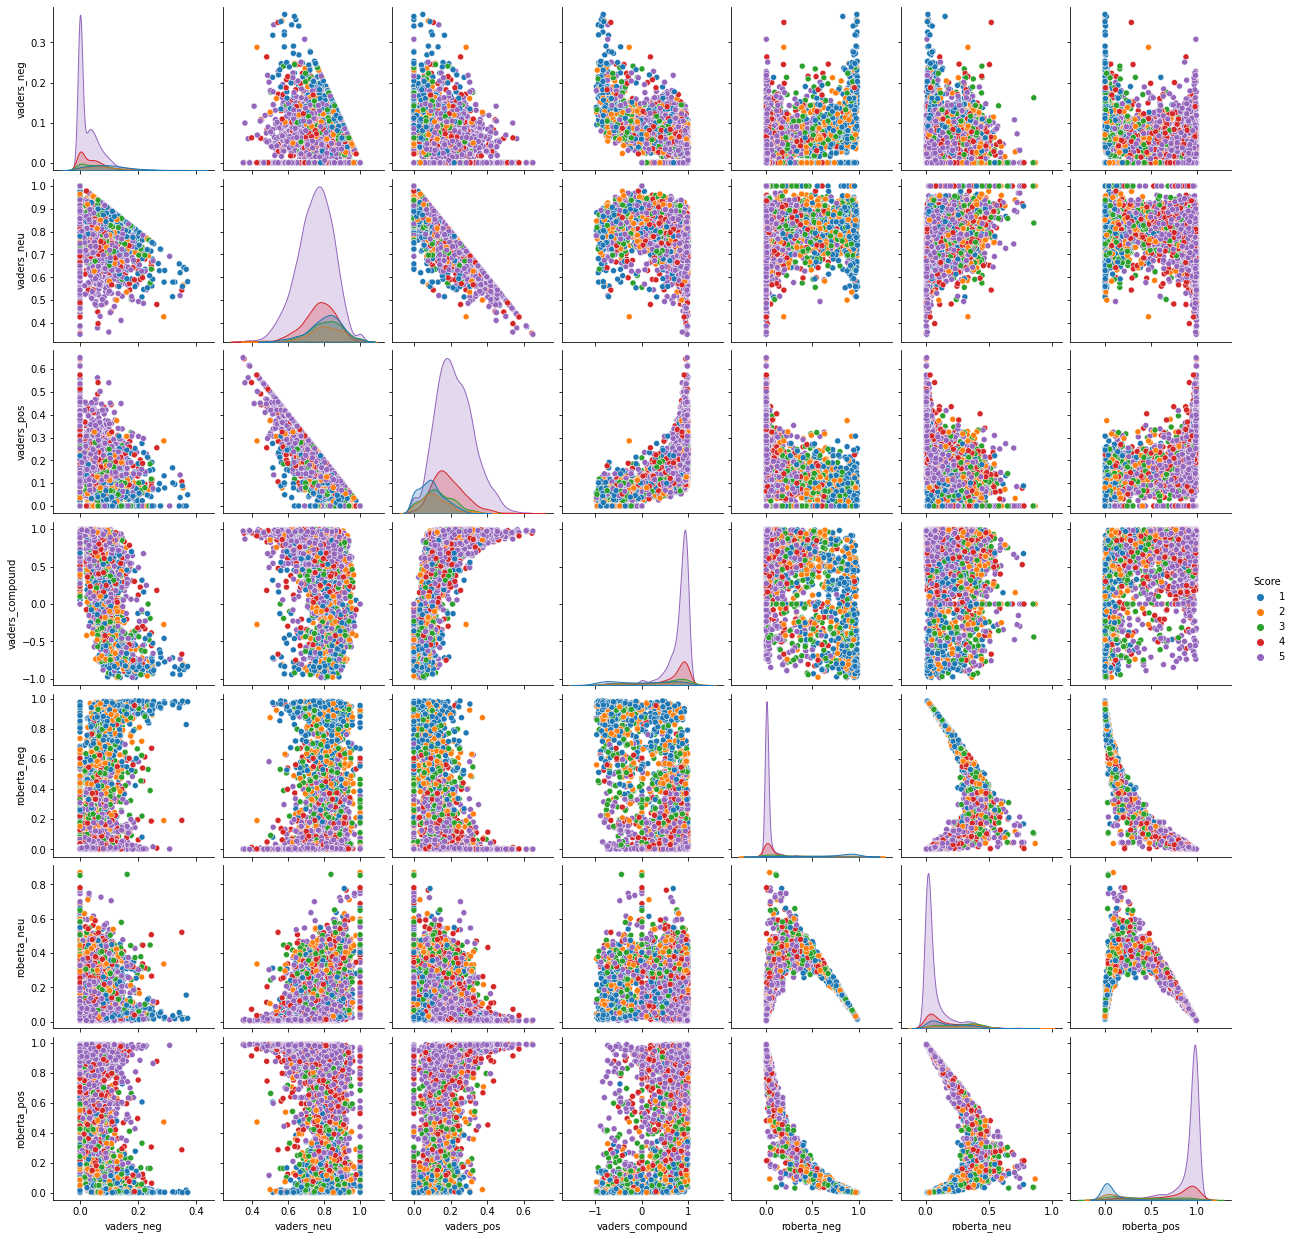

In [98]:
sns.pairplot(data = results_df,
             vars = ['vaders_neg','vaders_neu','vaders_pos','vaders_compound','roberta_neg','roberta_neu','roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

Checking the Star Ratings and Sentiment Scores given by the models

In [126]:
# Positive Sentiment with 1-Star review
print(results_df[results_df['Score']==1].sort_values(by='roberta_pos',ascending=False)[['Text','roberta_pos']].values[4])

['I had heard this was wonderful canned food, so I tried it for my very fussy schnauzer. I was first surprised to see a layer of fat on the top when I opened the can....I scraped that off and added a couple spoonfuls to her dry....and she sniffed it and walked away. She does seem to like the Merrick BG dry food. I chose the buffalo flavor and my girl says this is a winner.'
 0.8776590549570065]


In [113]:
# Negative Sentiment with 1-Star review
print(results_df[results_df['Score']==1].sort_values(by='roberta_neg',ascending=False)['Text'].values[200])

If you like strong coffee, as I do this coffee is over rated. I found it weak, with a sickening after  taste.


In [123]:
# Negative Sentiment with 5-Star review
print(results_df[results_df['Score']==5].sort_values(by='roberta_neg',ascending=False)[['Text','roberta_neg','roberta_pos']].values[4])

["I've eaten other brands of unsalted potato chips and they've always been terrible.  I didn't expect much when I bought these.  But after I tasted them I was amazed.  I have never enjoyed unsalted potato chips before these.  They have a natural potato flavor with thick, crunchy chips.  The only bad thing is the bag is a pain to open.  Use scissors and save yourself the aggravation."
 0.8786426679769669 0.021264463094156198]


# The END